In [ ]:
# math and data tools
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from random import sample
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
import itertools
import joblib
import datetime
import os
import pickle
import pdb
from IPython.display import display

import seaborn as sns
# plots
import matplotlib.pyplot as plt
# preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
# regression trees / random forests
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#tuning parameters and crossvalidation
from sklearn.model_selection import (GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate)
from sklearn.model_selection import (TimeSeriesSplit, RepeatedKFold, KFold, ShuffleSplit,    #different crosvalidation methods
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# drift coefficent
mu = 0.1
# time in years
T = 2
#steps per day
spd = 5
#tradingdays
td = 366
# number of steps
n = int(spd*td*T)
# number of sims
M = 500
# initial stock price
S0 = 100
# volatility
sigma = 0.3

# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
)

print(St.shape)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
St = np.round(S0 * St.cumprod(axis=0),2)

# Define time interval correctly
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

spc=spd*td
LSt=np.log(St)
LdifSt=LSt[1:,::]-LSt[:-1,::]
LdifStSq=LdifSt**2

dt=np.sum(LdifSt, axis=0)/T
print(np.mean(St[-1]/S0-1),np.median(St[-1]/S0-1),np.var(St[-1]/S0-1))
rvt=np.sum(LdifStSq, axis=0)
rvtt=(rvt/T)**0.5
print(rvt.shape)
print(np.mean(rvtt),np.median(rvtt),np.var(rvtt))

rv = np.zeros((n, M))
for i in range(spc, n):
    rv[i] = np.sum(LdifStSq[i-spc:i], axis=0)

rv7=np.zeros((n, M))
for i in range(spc, n):
    rv7[i] = np.average(rv[max(i-7,spc):i+1], axis=0)

rv15=np.zeros((n, M))
for i in range(spc, n):
    rv15[i] = np.average(rv[max(i-15,spc):i+1], axis=0)

rv30=np.zeros((n, M))
for i in range(spc, n):
    rv30[i] = np.average(rv[max(i-30,spc):i+1], axis=0)

features_crypto = ['strike_price', 'underlying_price', 'Tt','RV_lag0', 'RV_lag7', 'RV_lag15', 'RV_lag30','dummy_type_C','option_price']

startday=367
endday=547
startsample=startday*spd
endsample=endday*spd

Stf=St[startsample:endsample,:].flatten()
StSf=np.tile(St[startsample], endsample-startsample)
OTt=tt[endsample+1][0]-tt[startsample:endsample,:].flatten()
rvf=rv[startsample:endsample,:].flatten()
rv7f=rv7[startsample:endsample,:].flatten()
rv15f=rv15[startsample:endsample,:].flatten()
rv30f=rv30[startsample:endsample,:].flatten()

arr_2d = np.column_stack((StSf, Stf, OTt, rvf, rv7f, rv15f, rv30f))
print(Stf.shape,arr_2d.shape)

kr=[0.7, 0.9, 1, 1.1, 1.3]

#kr=[0.8, 0.95, 1.05, 1.2]

a_part = np.tile([1,0], len(kr))
b_part = np.repeat(kr, 2, axis=0)
r = np.column_stack((a_part, b_part))

c_part=np.tile(r, ((endsample-startsample)*M,1))
d_part=np.repeat(arr_2d, 2*len(kr), axis=0)
full=np.concatenate((d_part, c_part), axis=1)
full[:,0]=full[:,0]*full[:,8]
print(full.shape)
print(full)

def blackscholes(row):
  S = row[1]
  T = row[2]
  r = mu
  vol = row[3]**0.5
  K = row[0]
  d1 = (math.log(S/K) + (r + 0.5 * vol**2)*T ) / (vol * math.sqrt(T))
  d2 = d1 - (vol * math.sqrt(T))
  if row[7]==1:
    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
  else:
    return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

full[:,8]=np.apply_along_axis(blackscholes, axis=1, arr=full)
print(full)

header = ['strike_price', 'underlying_price', 'Tt','RV_lag0', 'RV_lag7', 'RV_lag15', 'RV_lag30','dummy_type_C','bs_option_price']
output_array = np.vstack((header, full))

means = np.mean(full, axis=0)
stds = np.std(full, axis=0)
percentiles = np.percentile(full, [0, 25, 50, 75, 100], axis=0)

print("stats")
print(means.tolist())
print(stds.tolist())
for i in percentiles.tolist():
  print(i)

np.savetxt('output.csv', output_array, delimiter=',', fmt='%s')
print("saved")

(3660, 500)
0.2278534 0.11129999999999995 0.28487746936843994
(500,)
0.2998952831734722 0.29974149652901316 1.3470992975530405e-05
ok


In [ ]:
crypto = pd.read_csv('output.csv') # augmented dataset with BV and SJV
label_crypto = 'bs_option_price'
features_crypto = ['strike_price', 'underlying_price', 'Tt','RV_lag0', 'RV_lag7', 'RV_lag15', 'RV_lag30','dummy_type_C'] # original features
y_crypto = crypto[label_crypto]
X_crypto = crypto[features_crypto]

X_train_crypto, X_test_crypto, y_train_crypto, y_test_crypto = train_test_split(X_crypto, y_crypto, test_size=0.9, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_crypto, y_train_crypto)

import xgboost as xgb
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_crypto, y_train_crypto)

X_train_crypto, X_test_crypto, y_train_crypto, y_test_crypto = train_test_split(X_test_crypto, y_test_crypto, test_size=0.1, random_state=42)

y_rf_crypto = rf_model.predict(X_test_crypto)
y_xgb_crypto = xgb_model.predict(X_test_crypto)

In [ ]:
crypto = pd.read_csv('output.csv') # augmented dataset with BV and SJV
label_crypto = 'bs_option_price'
features_crypto = ['strike_price', 'underlying_price', 'Tt','RV_lag0', 'RV_lag7', 'RV_lag15', 'RV_lag30','dummy_type_C'] # original features
y_crypto = crypto[label_crypto]
X_crypto = crypto[features_crypto]

X_train_crypto, X_test_crypto, y_train_crypto, y_test_crypto = train_test_split(X_crypto, y_crypto, test_size=0.9, random_state=42)

y_rf_crypto = rf_model.predict(X_test_crypto)
y_xgb_crypto = xgb_model.predict(X_test_crypto)

(2430000,)
RF model
R2: 0.987291
MSE: 147.18
MAE: 50.876
XGB model
R2: 0.981044
MSE: 179.746
MAE: 74.63


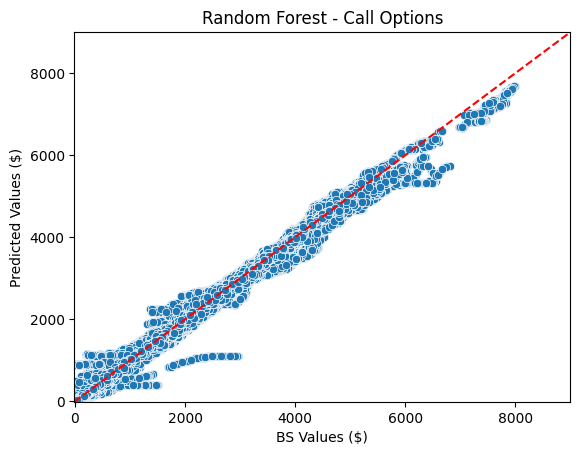

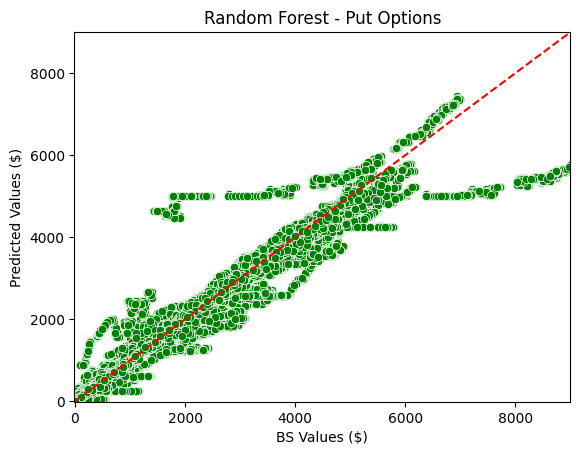

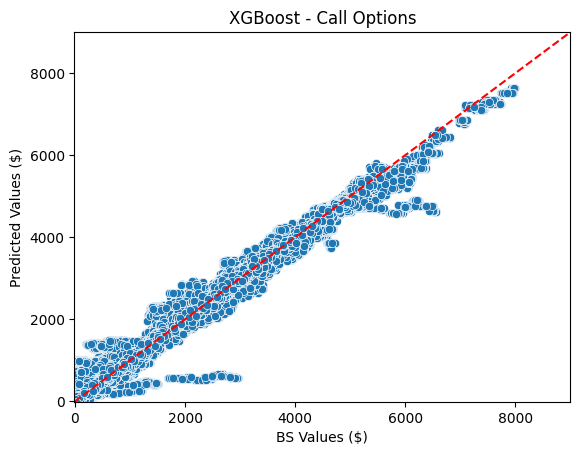

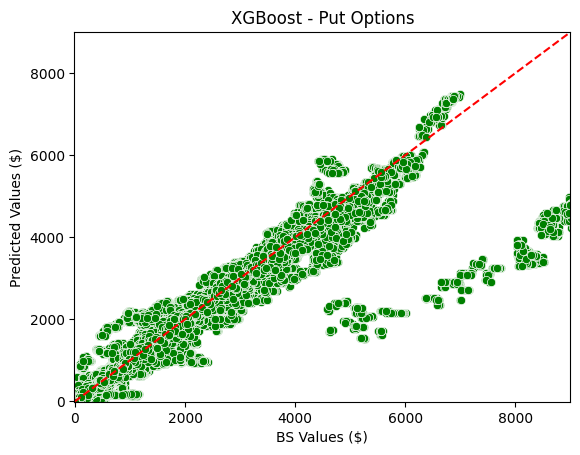

In [ ]:
print(y_test_crypto.shape)

fig,ax = plt.subplots(1,1)
sns.scatterplot(x=y_test_crypto[X_test_crypto['dummy_type_C'] == 1],y=y_rf_crypto[X_test_crypto['dummy_type_C'] == 1])
ax.axline((0, 0), slope=1,color='red', linestyle='--')
ax.set_xlim(left=-10, right=9000)
ax.set_ylim(bottom=-10, top=9000)
plt.xlabel('BS Values (\$)')
plt.ylabel('Predicted Values (\$)')
plt.title('Random Forest - Call Options')

fig,ax = plt.subplots(1,1)
sns.scatterplot(x=y_test_crypto[X_test_crypto['dummy_type_C'] == 0],y=y_rf_crypto[X_test_crypto['dummy_type_C'] == 0],color='green')
ax.axline((0, 0), slope=1,color='red', linestyle='--')
ax.set_xlim(left=-10, right=9000)
ax.set_ylim(bottom=-10, top=9000)
plt.xlabel('BS Values (\$)')
plt.ylabel('Predicted Values (\$)')
plt.title('Random Forest - Put Options')

fig,ax = plt.subplots(1,1)
sns.scatterplot(x=y_test_crypto[X_test_crypto['dummy_type_C'] == 1],y=y_xgb_crypto[X_test_crypto['dummy_type_C'] == 1])
ax.axline((0, 0), slope=1,color='red', linestyle='--')
ax.set_xlim(left=-10, right=9000)
ax.set_ylim(bottom=-10, top=9000)
plt.xlabel('BS Values (\$)')
plt.ylabel('Predicted Values (\$)')
plt.title('XGBoost - Call Options')

fig,ax = plt.subplots(1,1)
sns.scatterplot(x=y_test_crypto[X_test_crypto['dummy_type_C'] == 0],y=y_xgb_crypto[X_test_crypto['dummy_type_C'] == 0],color='green')
ax.axline((0, 0), slope=1,color='red', linestyle='--')
ax.set_xlim(left=-10, right=9000)
ax.set_ylim(bottom=-10, top=9000)
plt.xlabel('BS Values (\$)')
plt.ylabel('Predicted Values (\$)')
plt.title('XGBoost - Put Options')

r2_rf = round(r2_score(y_test_crypto, y_rf_crypto),6)
r2_xgb = round(r2_score(y_test_crypto, y_xgb_crypto),6)
mse_rf = round(mean_squared_error(y_test_crypto, y_rf_crypto, squared=False),3)
mse_xgb = round(mean_squared_error(y_test_crypto, y_xgb_crypto, squared=False),3)
mae_rf = round(mean_absolute_error(y_test_crypto, y_rf_crypto),3)
mae_xgb = round(mean_absolute_error(y_test_crypto, y_xgb_crypto),3)

print('RF model')
print('R2: {}'.format(r2_rf))
print('MSE: {}'.format(mse_rf))
print('MAE: {}'.format(mae_rf))

print('XGB model')
print('R2: {}'.format(r2_xgb))
print('MSE: {}'.format(mse_xgb))
print('MAE: {}'.format(mae_xgb))

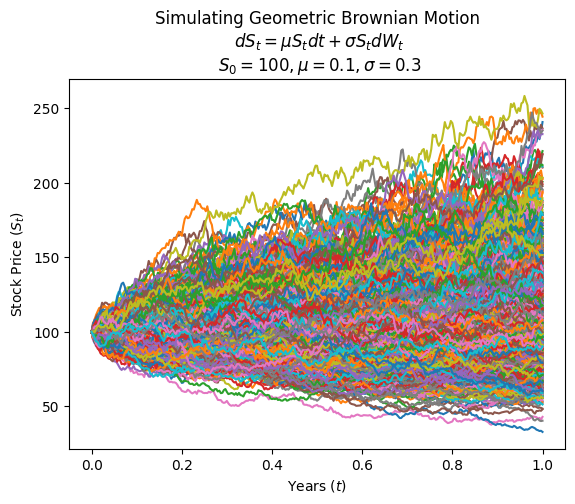

In [ ]:
plt.plot(tt, St)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Simulating Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

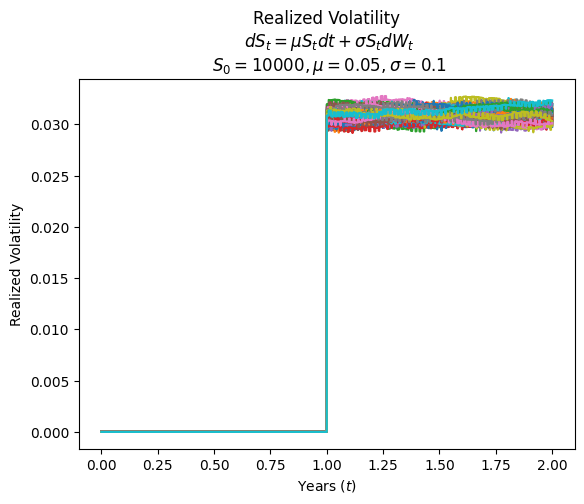

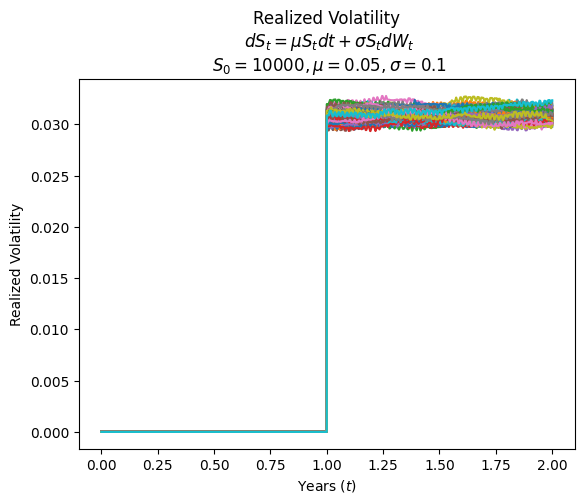

In [ ]:
plt.plot(tt[1:,:], rv)
plt.xlabel("Years $(t)$")
plt.ylabel("Realized Volatility")
plt.title(
    "Realized Volatility\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

plt.plot(tt[1:,:], rv30)
plt.xlabel("Years $(t)$")
plt.ylabel("Realized Volatility")
plt.title(
    "Realized Volatility\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

<ipython-input-4-2ce08f5bf78d>:10: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r + 0.5 * vol**2)*T ) / (vol * (T)**0.5)


(365, 100)
(365, 100)


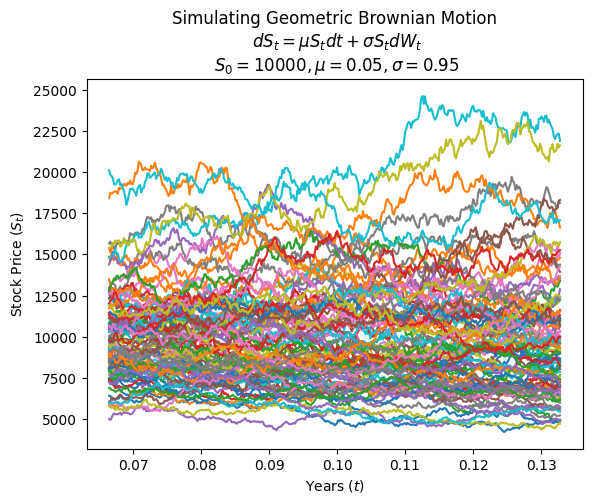

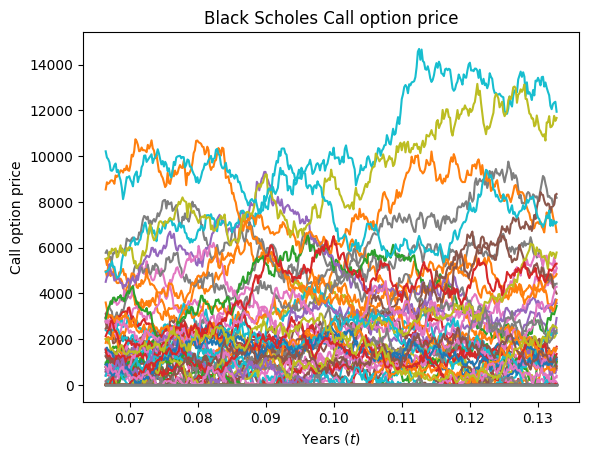

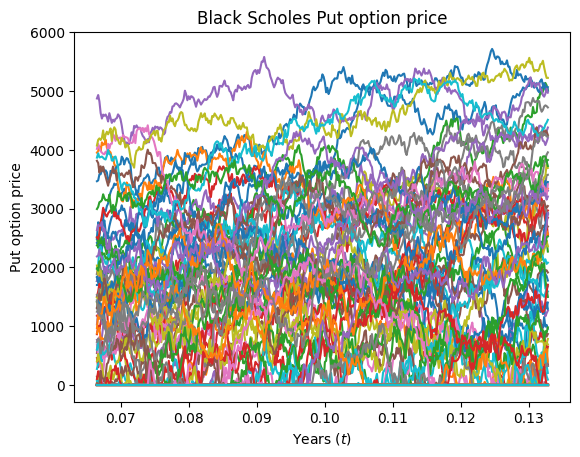

In [ ]:
import math
from scipy.stats import norm

S = St[365:365*2,:]
T = 2*np.ones_like(tt[365:365*2,:])-tt[365:365*2,:]
r = 0.1*np.ones_like(tt[365:365*2,:])
vol = rv[365:365*2,:]**0.5
K = 12000*np.ones_like(tt[365:365*2,:])

d1 = (np.log(S/K) + (r + 0.5 * vol**2)*T ) / (vol * (T)**0.5)
d2 = d1 - (vol * (T)**0.5)
C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
P = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

print(C.shape)
print(P.shape)

plt.plot(tt[365:365*2,:], St[365:365*2,:])
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Simulating Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

plt.plot(tt[365:365*2,:], C)
plt.xlabel("Years $(t)$")
plt.ylabel("Call option price")
plt.title("Black Scholes Call option price")
plt.show()

plt.plot(tt[365:365*2,:], P)
plt.xlabel("Years $(t)$")
plt.ylabel("Put option price")
plt.title("Black Scholes Put option price")
plt.show()

In [ ]:
Stf=St[366:366+365,:].flatten()
rvf=rv[365:365+365,:].flatten()
rv7f=rv7[365:365+365,:].flatten()
rv15f=rv15[365:365+365,:].flatten()
rv30f=rv30[365:365+365,:].flatten()

arr_2d = np.column_stack((Stf, rvf, rv7f, rv15f, rv30f))
print(Stf.shape,arr_2d.shape)
print(arr_2d)

In [ ]:
import math
from scipy.stats import norm

S = 10000
T = 2
r = 0.1
vol = 0.3
K = 12000

d1 = (math.log(S/K) + (r + 0.5 * vol**2)*T ) / (vol * math.sqrt(T))
d2 = d1 - (vol * math.sqrt(T))

C = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
P = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

print('The value of d1 is: ', round(d1, 4))
print('The value of d2 is: ', round(d2, 4))
print('The price of the call option is: $', round(C, 2))
print('The price of the put option is: $', round(P, 2))